# Regresión lineal: predecir los gastos médicos de pacientes
---

Para este ejercicio utilizaremos los datos presentados en [este](https://www.kaggle.com/mirichoi0218/insurance) dataset de Kaggle en el cual se presentan datos de seguros médicos. 


## Descarga e instalación de librerías

Lo primero que se hará es descargar la librería **[regressors](https://pypi.org/project/regressors/)** que ayudará a hacer un análisis más profundo sobre la regresión lineal.

In [186]:
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
import plotly.express as px

## Descargando los datos
Descarguemos los datos y veamos cómo se ven.

In [187]:
df = pd.read_csv('/Users/andressanchez/Desktop/Data Scientist/Linear Regression Course with Python and scikit-learn/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Analizando los datos
Se observará cómo se distribuyen los datos de la variable a predecir.

(1338, 7)


<AxesSubplot:>

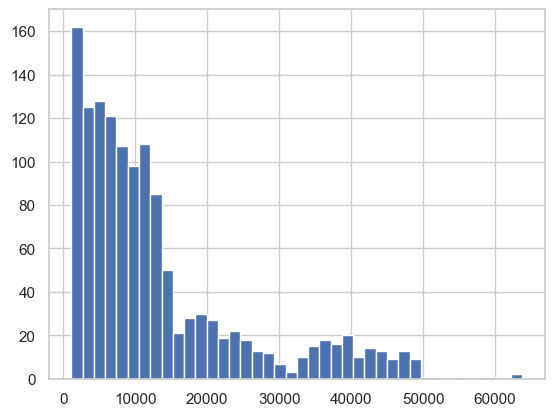

In [188]:
print(df.shape)
df.charges.hist(bins=40)

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [189]:
df[df.charges > 50000]
df = df[df.charges < 50000]

En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio. 

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

In [190]:
import pandas as pd

def detectar_outliers(df, threshold=1.5):
    """
    Detecta y muestra los outliers en todas las columnas numéricas del DataFrame utilizando el método IQR.
    
    Parameters:
        - df (pd.DataFrame): El DataFrame en el que se realizará la detección de outliers.
        - threshold (float): Umbral para identificar outliers. El valor por defecto es 1.5.
    """
    for column_name in df.columns:
        if pd.api.types.is_numeric_dtype(df[column_name]):
            Q1 = df[column_name].quantile(0.25)
            Q3 = df[column_name].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
            
            print(f"Outliers en la columna '{column_name}':")
            print(outliers)
            print("\n")

# Ejemplo de uso
data = df

df = pd.DataFrame(data)

detectar_outliers(df)


Outliers en la columna 'age':
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []


Outliers en la columna 'bmi':
      age     sex    bmi  children smoker     region     charges
116    58    male  49.06         0     no  southeast  11381.3254
286    46  female  48.07         2     no  northeast   9432.9253
401    47    male  47.52         1     no  southeast   8083.9198
847    23    male  50.38         1     no  southeast   2438.0552
860    37  female  47.60         2    yes  southwest  46113.5110
1047   22    male  52.58         1    yes  southeast  44501.3982
1088   52    male  47.74         1     no  southeast   9748.9106
1317   18    male  53.13         0     no  southeast   1163.4627


Outliers en la columna 'children':
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []


Outliers en la columna 'charges':
      age     sex     bmi  children smoker     region      charges
14     27    male  42.130         0    ye

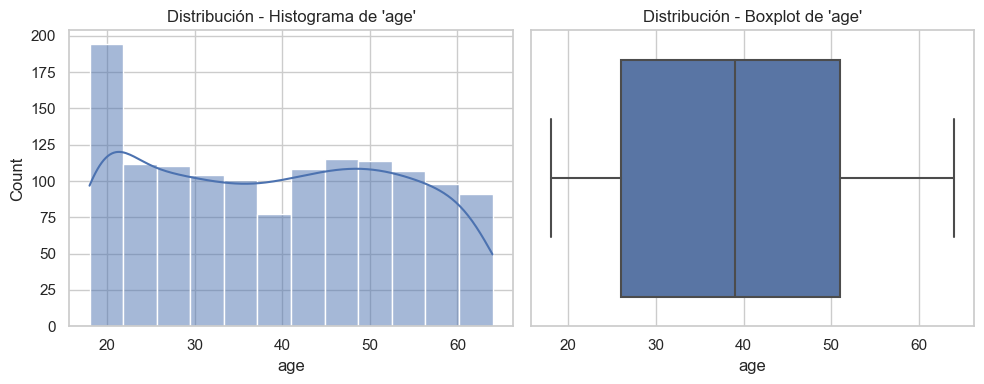

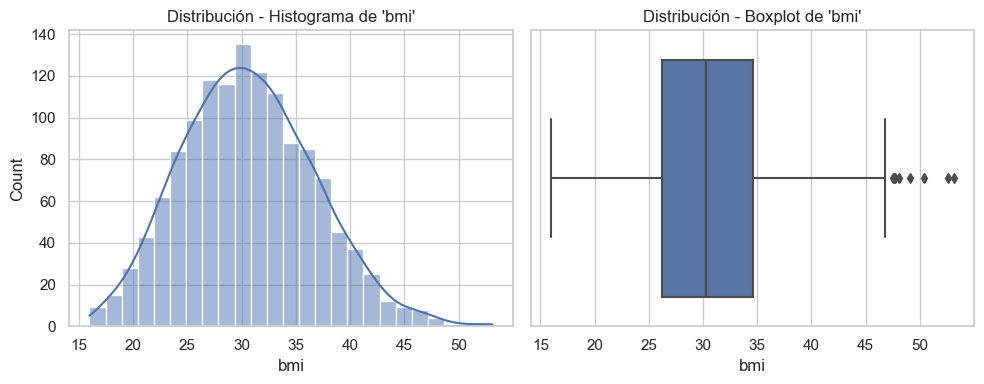

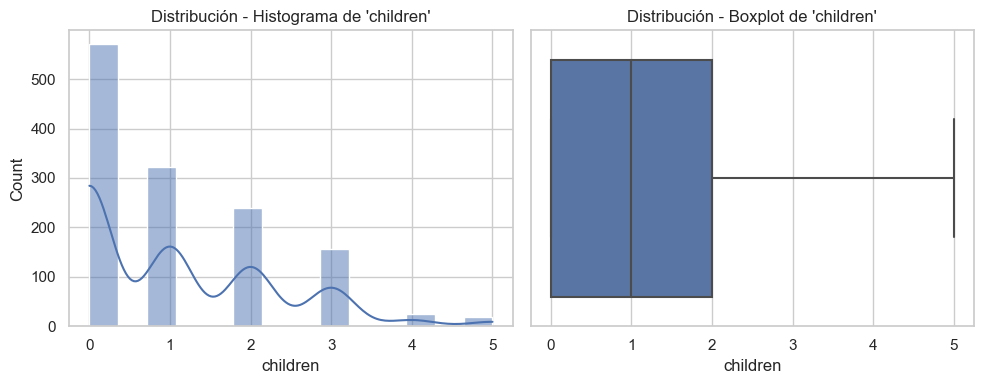

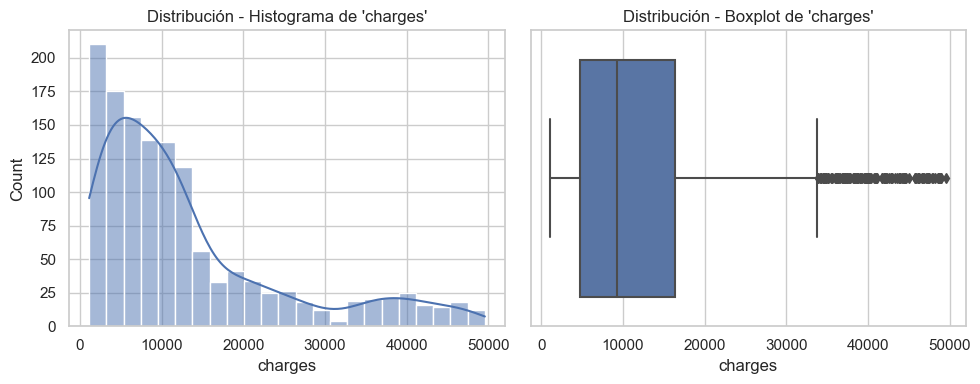

In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def mostrar_distribucion(df):
    """
    Muestra la distribución de cada variable numérica en el DataFrame mediante histogramas y boxplots.
    
    Parameters:
        - df (pd.DataFrame): El DataFrame del que se mostrará la distribución.
    """
    numeric_columns = df.select_dtypes(include='number').columns
    for column_name in numeric_columns:
        plt.figure(figsize=(10, 4))
        
        # Histograma
        plt.subplot(1, 2, 1)
        sns.histplot(df[column_name], kde=True)
        plt.xlabel(column_name)
        plt.title(f"Distribución - Histograma de '{column_name}'")
        
        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[column_name])
        plt.xlabel(column_name)
        plt.title(f"Distribución - Boxplot de '{column_name}'")
        
        plt.tight_layout()
        plt.show()

# Ejemplo de uso
data = df

df = pd.DataFrame(data)

mostrar_distribucion(df)


## Viendo correlaciones
Ahora entendamos nuestros datos, viendo cómo se distribuyen y correlacionan. 

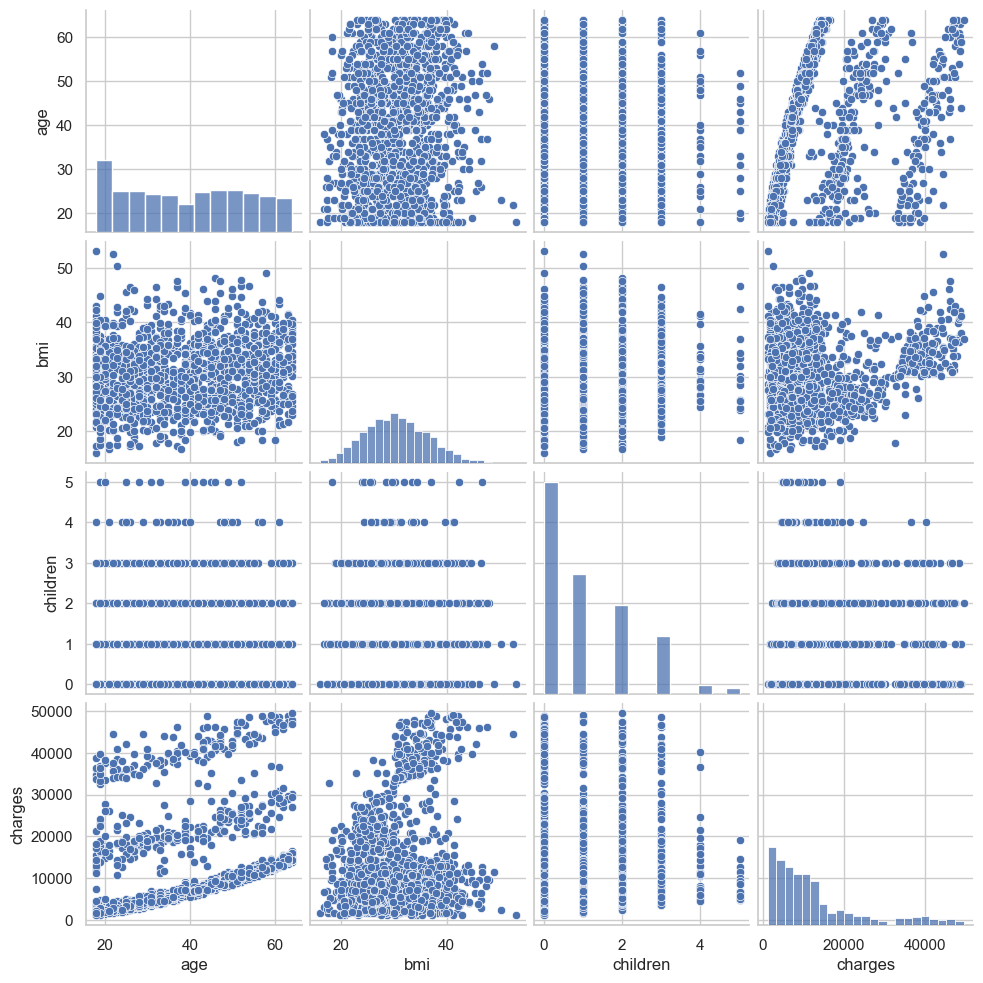

In [192]:
sns.pairplot(df, height=2.5);

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

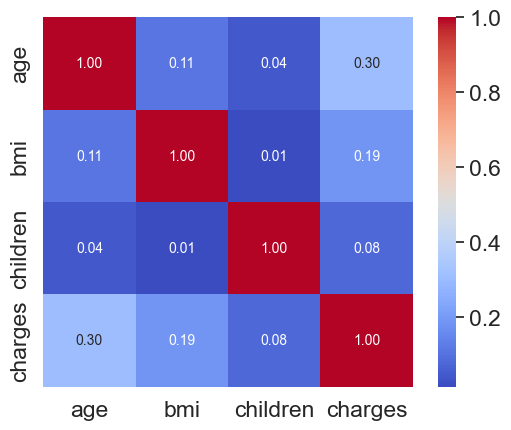

In [193]:
numeric_cols = df.select_dtypes(include='number').columns
cm = np.corrcoef(df[numeric_cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=numeric_cols, xticklabels=numeric_cols, cmap='coolwarm')
plt.show()

## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función get_dummies de pandas. 

Ahora la verás en acción

In [194]:
import pandas as pd

def one_hot_encoding(df):
    """
    Aplica one-hot encoding a las variables categóricas en el DataFrame y devuelve un nuevo DataFrame con las variables codificadas.

    Parameters:
        - df (pd.DataFrame): El DataFrame original que contiene las variables categóricas.

    Returns:
        - pd.DataFrame: Un nuevo DataFrame con las variables categóricas codificadas.
    """
    # Identificar las columnas categóricas
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Aplicar one-hot encoding a las columnas categóricas
    df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True) # drop_first=True para evitar la multicolinealidad

    return df_encoded

# Ejemplo de uso
data = df

df = pd.DataFrame(data)

df_encoded = one_hot_encoding(df)
print(df_encoded)
df_encoded.head()


      age     bmi  children      charges  sex_male  smoker_yes  \
0      19  27.900         0  16884.92400         0           1   
1      18  33.770         1   1725.55230         1           0   
2      28  33.000         3   4449.46200         1           0   
3      33  22.705         0  21984.47061         1           0   
4      32  28.880         0   3866.85520         1           0   
...   ...     ...       ...          ...       ...         ...   
1333   50  30.970         3  10600.54830         1           0   
1334   18  31.920         0   2205.98080         0           0   
1335   18  36.850         0   1629.83350         0           0   
1336   21  25.800         0   2007.94500         0           0   
1337   61  29.070         0  29141.36030         0           1   

      region_northwest  region_southeast  region_southwest  
0                    0                 0                 1  
1                    0                 1                 0  
2                    0  

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


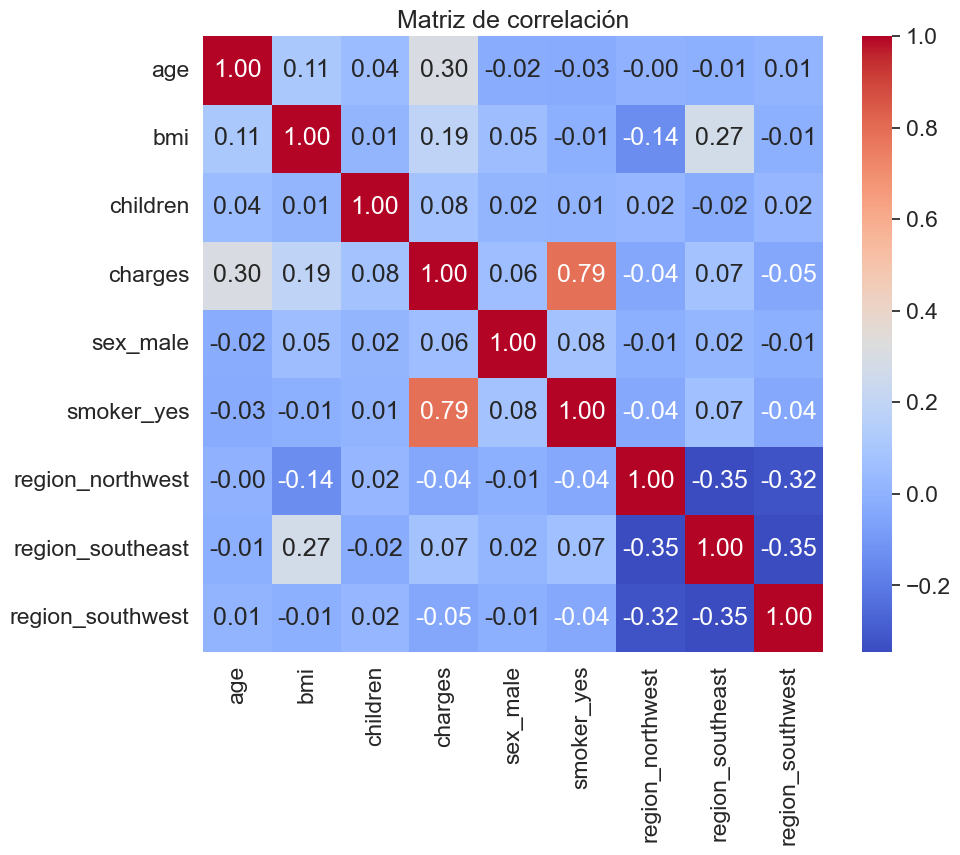

                       age       bmi  children   charges  sex_male  \
age               1.000000  0.108331  0.043197  0.304561 -0.022425   
bmi               0.108331  1.000000  0.014860  0.187061  0.048915   
children          0.043197  0.014860  1.000000  0.076993  0.016042   
charges           0.304561  0.187061  0.076993  1.000000  0.057519   
sex_male         -0.022425  0.048915  0.016042  0.057519  1.000000   
smoker_yes       -0.028377 -0.006159  0.011084  0.785617  0.075786   
region_northwest -0.000367 -0.136642  0.022816 -0.043506 -0.010787   
region_southeast -0.013238  0.270376 -0.021127  0.074787  0.017669   
region_southwest  0.009735 -0.005691  0.022816 -0.045242 -0.007282   

                  smoker_yes  region_northwest  region_southeast  \
age                -0.028377         -0.000367         -0.013238   
bmi                -0.006159         -0.136642          0.270376   
children            0.011084          0.022816         -0.021127   
charges             0.78561

In [195]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analisis_correlacion(df):
    """
    Realiza el análisis de correlación entre todas las variables numéricas del DataFrame y muestra un heatmap.

    Parameters:
        - df (pd.DataFrame): El DataFrame que contiene las variables numéricas.

    Returns:
        - pd.DataFrame: Un DataFrame con la matriz de correlación entre las variables numéricas.
    """
    # Filtrar solo las columnas numéricas
    numeric_columns = df.select_dtypes(include='number')

    # Calcular la matriz de correlación
    correlation_matrix = numeric_columns.corr()

    # Visualizar la matriz de correlación en un heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Matriz de correlación')
    plt.show()

    return correlation_matrix

# Ejemplo de uso
data = df_encoded
df = pd.DataFrame(data)

matriz_correlacion = analisis_correlacion(df)
print(matriz_correlacion)


In [196]:
fig = px.imshow(
    df_encoded.corr(),
    color_continuous_scale=px.colors.diverging.RdBu[::-1],
    text_auto=True,
    zmin=-1,
    zmax=1,
)

fig.show()
df_encoded.corr().style.background_gradient(cmap="coolwarm", axis=None)

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.108331,0.043197,0.304561,-0.022425,-0.028377,-0.000367,-0.013238,0.009735
bmi,0.108331,1.000000,0.014860,0.187061,0.048915,-0.006159,-0.136642,0.270376,-0.005691
children,0.043197,0.014860,1.000000,0.076993,0.016042,0.011084,0.022816,-0.021127,0.022816
charges,0.304561,0.187061,0.076993,1.000000,0.057519,0.785617,-0.043506,0.074787,-0.045242
sex_male,-0.022425,0.048915,0.016042,0.057519,1.000000,0.075786,-0.010787,0.017669,-0.007282
smoker_yes,-0.028377,-0.006159,0.011084,0.785617,0.075786,1.000000,-0.038487,0.069074,-0.038487
region_northwest,-0.000367,-0.136642,0.022816,-0.043506,-0.010787,-0.038487,1.000000,-0.345990,-0.320437
region_southeast,-0.013238,0.270376,-0.021127,0.074787,0.017669,0.069074,-0.345990,1.000000,-0.345990
region_southwest,0.009735,-0.005691,0.022816,-0.045242,-0.007282,-0.038487,-0.320437,-0.345990,1.000000


## Creando modelos 
Primero se usará un modelo con todas las variables.

In [197]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [198]:
X_cols = list(set(df_encoded.columns) - set(['charges'])) # Seleccionar todas las columnas menos 'charges' como variables predictoras utilizando set para evitar duplicados
y_col = ['charges'] # Seleccionar la columna 'charges' como variable objetivo

X = df_encoded[X_cols].values
y = df_encoded[y_col].values

# Dividir el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

# Escalar los datos

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

# Entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [199]:
y_pred.shape

(333, 1)

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

In [200]:
import sklearn.metrics as metrics
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse.round(2)}") 
print(f"R-squared (R2 ): {r2.round(2)}") # > 0.75 es un buen modelo

# Cuando se tiene un modelo que predice el 100% de los daots, está sobreajustado

Mean Squared Error (MSE): 0.21
R-squared (R2 ): 0.77


El siguiente código muestra un resumen general de los resultados.

In [201]:
from regressors import stats
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

In [202]:
y_test = y_test.reshape(-1)

print('================Summary================')
stats.summary(model, X_test, y_test, X_cols)

================Summary================
Residuals:
    Min      1Q  Median     3Q    Max
-2.0172 -0.0704  0.1149 0.2897 0.9614


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept        0.018507    0.025137   0.7362  0.462114
region_southeast -0.027463    0.030233  -0.9084  0.364341
bmi               0.170818    0.025456   6.7102  0.000000
region_southwest -0.027440    0.030306  -0.9055  0.365883
sex_male         -0.008501    0.025185  -0.3375  0.735933
region_northwest -0.000842    0.029070  -0.0290  0.976917
smoker_yes        0.806312    0.025945  31.0772  0.000000
children          0.049888    0.026777   1.8631  0.063329
age               0.303382    0.025167  12.0547  0.000000
---
R-squared:  0.76557,    Adjusted R-squared:  0.75978
F-statistic: 132.26 on 8 features


Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

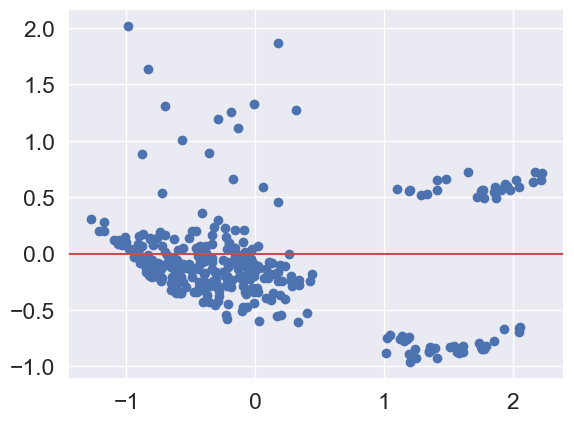

In [203]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.axhline(y=0, color='r', linestyle='-')
plt.scatter(y_pred, residuals);


## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

In [204]:
# Se agregan mas variables al modelo para mejorar la predicción
# Estas variables tienen que ver con la percepcion del científico sobre cuales sean más importantes para el modelo
df_second = df_encoded.copy()
df_second['age^2'] = df_second['age']**2
df_second['sobrepeso'] = (df_second['bmi'] > 30).astype(int)
df_second['sobrepeso*fumador'] = df_second['sobrepeso'] * df_second['smoker_yes']

Analizando el segundo modelo

In [205]:
X_cols = ['sobrepeso*fumador','smoker_yes','age^2','children'] # Seleccionar todas las columnas menos 'charges' como variables predictoras utilizando set para evitar duplicados
y_col = ['charges'] # Seleccionar la columna 'charges' como variable objetivo

X = df_second[X_cols].values
y = df_second[y_col].values

# Dividir el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y)
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

# Escalar los datos

X_train = sc_x.transform(X_train)
X_test = sc_x.transform(X_test)
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

# Entrenar el modelo
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [206]:
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse.round(2)}") 
print(f"R-squared (R2 ): {r2.round(2)}") # > 0.75 es un buen modelo


Mean Squared Error (MSE): 0.11
R-squared (R2 ): 0.87


In [207]:

model.coef_ = model.coef_.reshape(-1)

In [208]:
y_test = y_test.reshape(-1)

print('================Summary================')
stats.summary(model, X_test, y_test, X_cols)

================Summary================
Residuals:
    Min     1Q  Median     3Q    Max
-1.9221 0.0702  0.1109 0.1421 0.2979


Coefficients:
                   Estimate  Std. Error  t value   p value
_intercept         0.000000    0.018400   0.0000  1.000000
sobrepeso*fumador  0.492901    0.024094  20.4573  0.000000
smoker_yes         0.463412    0.022444  20.6473  0.000000
age^2              0.326259    0.018907  17.2563  0.000000
children           0.071648    0.018250   3.9260  0.000105
---
R-squared:  0.86789,    Adjusted R-squared:  0.86627
F-statistic: 538.67 on 4 features


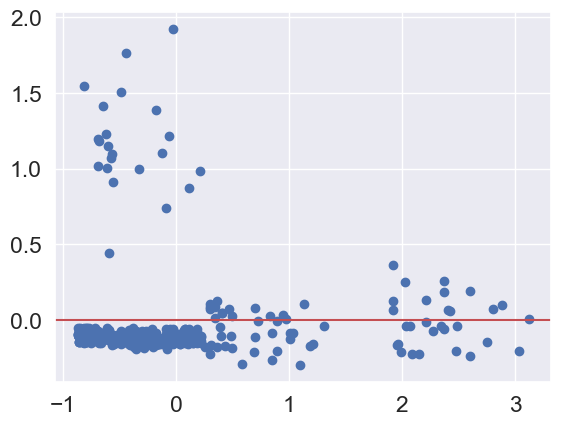

In [210]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.axhline(y=0, color='r', linestyle='-')
plt.scatter(y_pred, residuals);
